- [Reference video](https://www.bilibili.com/video/BV1Y44y1b7ke/)
- State-transition equation:
$$x(k+1)=\underbrace{A}_{n \times n}\underbrace{x(k)}_{n \times 1}+\underbrace{B}_{n \times p}\underbrace{u(k)}_{p \times 1}$$
- Prediction horizon function:
$$
X(k)=Mx(k) + CU(k)
$$
- In this function(N is horizon)
$$
X(k) =
\underbrace{
\begin{bmatrix}
x(k|k) \\
x(k+1|k) \\
\vdots \\
x(k+i|k) \\
\vdots \\
x(k+N|k) \\
\end{bmatrix}
}_{n(N+1) \times 1}
\quad \\
U(k)=
\underbrace{
\begin{bmatrix}
u(k|k) \\
u(k+1|k) \\
\vdots \\
u(k+i|k) \\
\vdots \\
u(k+N-1|k) \\
\end{bmatrix}
}_{Np \times 1}
\quad \\
M =
\underbrace{
\begin{bmatrix}
I_{n \times n} \\
A_{n \times n} \\
A_2 \\
\vdots \\
A_N \\
\end{bmatrix}
}_{n(N+1) \times n}
\quad \\
C =
\underbrace{
\begin{bmatrix}
0 & 0 & \cdots & 0 \\
\vdots & \vdots & \cdots & \vdots \\
0 & 0 & & 0 \\
B & 0 & \cdots & 0 \\
AB & B & \cdots & 0 \\
\vdots & \vdots & \ddots & 0 \\
A^{N-1}B & A^{N-2}B & \cdots & B \\
\end{bmatrix}
}_{n(N+1) \times Np}
$$


- Cost function:
$$
J = (MX_k+CU_k-x^*)^T\overline{Q}(MX_k+CU_k-x^*) + (U_k)^T\overline{R}(U_k)
$$
- In this funciton
- $Q(error),R(input)$ are adjustment matrixs
$$
\overline{Q} =
\begin{bmatrix}
Q & \cdots &  \\
\vdots & Q & \vdots \\
  & \cdots & F \\
\end{bmatrix}
\quad \\
\overline{R} =
\begin{bmatrix}
R & \cdots &  \\
\vdots & \ddots & \vdots \\
  & \cdots & R \\
\end{bmatrix}
$$

In [190]:
import sympy


def solve(mat: sympy.Matrix, symbol: sympy.MatrixSymbol, val):
    return mat.subs(symbol, val)


def M(N: int, A: sympy.Matrix):
    return sympy.BlockMatrix([[sympy.Matrix(A**i)] for i in range(N + 1)]).as_explicit()


def C(N: int, A: sympy.Matrix, B: sympy.Matrix):
    n, p = (A * B).shape
    res_up = sympy.BlockMatrix([[sympy.zeros(n, p) for i in range(N)]]).as_explicit()
    res_down = sympy.BlockMatrix(
        [
            [
                A ** (N - j) * (A ** (N - i)).inv() * B if i >= j else sympy.zeros(n, p)
                for j in range(N)
            ]
            for i in range(N)
        ]
    ).as_explicit()
    return sympy.BlockMatrix([[res_up], [res_down]]).as_explicit()


def Q_BAR(N: int, Q: sympy.Matrix, F: sympy.Matrix):
    return sympy.BlockDiagMatrix(*([Q for _ in range(N)] + [F])).as_explicit()


def R_BAR(N: int, R: sympy.Matrix):
    return sympy.BlockDiagMatrix(*([R for _ in range(N)])).as_explicit()

- ex($n,p=3,2$):
$$
\begin{bmatrix}
x_1(k+1) \\
x_2(k+1) \\
\end{bmatrix}
=  
\begin{bmatrix}
1  & 0.1 \\
-1  & -2 \\
\end{bmatrix}
\begin{bmatrix}
x_1(k) \\
x_2(k) \\
\end{bmatrix}
+
\begin{bmatrix}
0.2 & 1 \\
0.5 & 2 \\
\end{bmatrix}u(k)
$$

In [191]:
# State,input dimensions
n, p = 2, 2
# Prediction horizon
N = 5

"""
# Also use symbolic calculations to view the results
# All results are symbols rather than numbers
# Example:
A_SYM = sympy.MatrixSymbol("A", n, n)
B_SYM = sympy.MatrixSymbol("B", n, p)
Q_SYM = sympy.MatrixSymbol("Q", n, n)
F_SYM = sympy.MatrixSymbol("F", n, n)
R_SYM = sympy.MatrixSymbol("R", p, p)
"""
# State transition matrix
A_VAL = sympy.Matrix([[1, 0.1], [-1, 2]])
B_VAL = sympy.Matrix([[0.2, 1], [0.5, 2]])
# Adjustment matrix
Q_VAL = sympy.Matrix([[100, 0], [0, 1]])
F_VAL = sympy.Matrix([[100, 0], [0, 1]])
R_VAL = sympy.Matrix([[1, 0], [0, 0.1]])

Q_BAR_VAL = Q_BAR(N, Q_VAL, F_VAL)
R_BAR_VAL = R_BAR(N, R_VAL)

C_VAL = C(N, A_VAL, B_VAL)
M_VAL = M(N, A_VAL)

In [214]:
import numpy
import casadi


# run 100 step
steps = 100

# use numpy
A_NP = numpy.array(A_VAL).astype(numpy.float64)
B_NP = numpy.array(B_VAL).astype(numpy.float64)

C_NP = numpy.array(C_VAL).astype(numpy.float64)
M_NP = numpy.array(M_VAL).astype(numpy.float64)

Q_BAR_NP = numpy.array(Q_BAR_VAL).astype(numpy.float64)
R_BAR_NP = numpy.array(R_BAR_VAL).astype(numpy.float64)

# x_target = numpy.array([[0], [0]])
x_target = numpy.array([[0], [0]])
X_TARGET = numpy.zeros((N + 1) * n)

for i in range(n):
    X_TARGET[:: (i + 1)] = x_target[n - i - 1]
X_TARGET = X_TARGET.reshape(((N + 1) * n), 1)

# state init
X = numpy.array([[[20], [-20]]])
# input init
U = numpy.array([[[0], [0]]])

U_SYM = casadi.SX.sym("U", N * p)


constraints = []


U_START = numpy.zeros((N * p, 1))

for i in range(steps):
    XK = M_NP @ X[-1] - X_TARGET + C_NP @ U_SYM
    J_NP = XK.T @ Q_BAR_NP @ XK + U_SYM.T @ R_BAR_NP @ U_SYM

    solver = casadi.nlpsol(
        "solver",
        "ipopt",
        {"x": U_SYM, "f": J_NP, "g": casadi.vertcat(*constraints)},
        {"ipopt.print_level": 0, "print_time": False},
    )
    u_i = solver(x0=U_START)["x"].toarray()[:p]
    new_state = numpy.array([A_NP @ X[-1] + B_NP @ u_i]).astype(numpy.float64)
    U = numpy.append(U, numpy.array([u_i]), axis=0)
    X = numpy.append(X, new_state, axis=0)
# X, U

ValueError: x and y must have same first dimension, but have shapes (101,) and (1,)

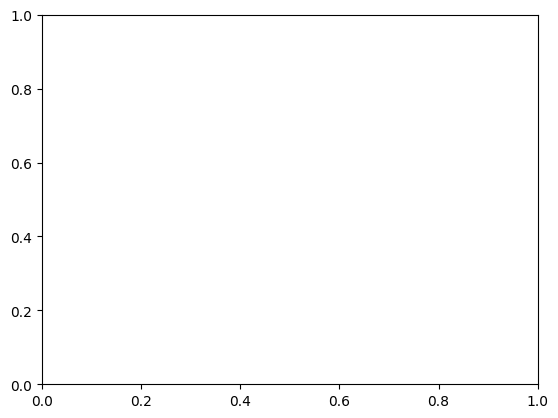

In [193]:
import matplotlib.pyplot as plt

k = numpy.linspace(0, steps + 1, steps + 1)

x1 = X[:, 0, 0]
x2 = X[:, 1, 0]
plt.plot(k, x1, label="x1", color="blue")
plt.plot(k, x2, label="x2", color="red")

plt.title("MPC-state")
plt.xlabel("steps")
plt.ylabel("state val")
plt.legend()
plt.grid()

plt.figure()

U = U[1:]
u1 = U[:, 0]
u2 = U[:, 1]
plt.plot(k[:-1], u1, label="u1", color="blue")
plt.plot(k[:-1], u2, label="u2", color="red")

plt.title("MPC-input")
plt.xlabel("steps")
plt.ylabel("input val")
plt.legend()
plt.grid()

plt.show()